# CS 441 - Spring 2024 - Final Project Code (House Price Regression)
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

Link to report template: https://docs.google.com/document/d/11p3BUsx8qoAWdBEVn_Tc-_Nw16XrGhEmwk8RTRH7bOg/edit?usp=sharing

Created By: svmore2, anahas2, sk153



# Importing Data & Packages

In [5]:
import numpy as np
from google.colab import drive
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd

In [6]:
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/MyDrive/CS441/24SP/finalProject/house-prices-advanced-regression-techniques/" # TO DO: set up ur directory in drive to be this here
train_data = pd.read_csv(datadir + 'train.csv')
test_data = pd.read_csv(datadir + 'test.csv')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# test_data.info()

# Random Forest

#### Feature Engineering

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [16]:
'''
Seperate target from the predictors
'''
y = train_data['SalePrice']
X_train = train_data.drop(['SalePrice'], axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [17]:
'''
Find the columns from the training data that are numerical vs not numerical.

Tree Classification Algos like Random Forest handle cardinality better than Linear models but still lets not include categorical features with
nunique > 10 as it may pose challenges like overfitting. (this is for nonNumericalCols)
'''
def identify_columns(data):
    numerical_cols = []
    categorical_cols = []
    for col in data.columns:
        if data[col].dtype == "int64" or data[col].dtype == "float64":
            numerical_cols.append(col)
        elif data[col].dtype == "object" and data[col].nunique() < 10:
            categorical_cols.append(col)
    return numerical_cols, categorical_cols

numericalCols, categoricalCols = identify_columns(X_train)
numericalColsTest, categoricalColsTest = identify_columns(X_test)
numericalColsVal, categoricalColsVal = identify_columns(X_val)

In [ ]:
# Preprocess the numericalCols: any missing vals in cols replace with the median of that column
numerical_transformer = SimpleImputer(strategy='median')

# Preprocess categorical data: imputer will handle the missing vals by replacing the vals with the most frequent in that col, onehot turns val into one hot encoded vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

#### Identify Key Hyperparameters & Define Model

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', grid_search)
])

# grid search will look at the different combinations of the param grid and keep track of the neg_mean_squared_error for each model it fits
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_split', 'param_n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'rmse'],
      dtype='object')


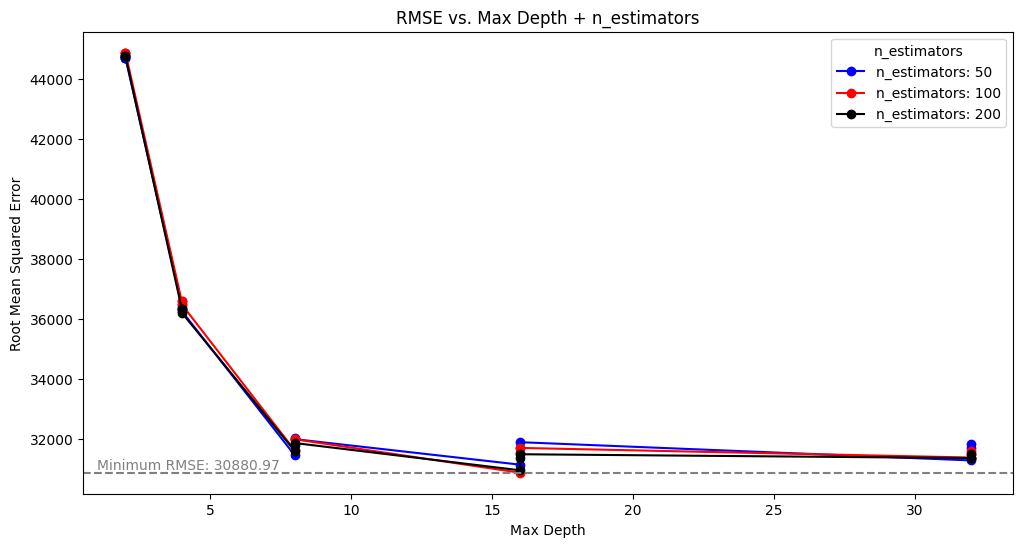

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cv_results = grid_search.cv_results_
results_df = pd.DataFrame(cv_results)
results_df['rmse'] = np.sqrt(-results_df['mean_test_score']) # created new column for the RMSE
print(results_df.columns)

colors = {50: 'blue', 100: 'red', 200: 'black'}
estimators_values = results_df['param_n_estimators'].unique()

# Plot how RMSE changes with the max_depth + n_estimators
plt.figure(figsize=(12, 6))
for n in estimators_values:
    subset = results_df[results_df['param_n_estimators'] == n] # create df of just rows with n=50 for example
    plt.plot(subset['param_max_depth'], subset['rmse'], label=f'n_estimators: {n}', color=colors[n], marker='o')

# Get the min RMSE val and draw a dotted line there
min_rmse = results_df['rmse'].min()
plt.axhline(y=min_rmse, color='gray', linestyle='--', linewidth=1.5)
plt.text(x=1, y=min_rmse, s=f'Minimum RMSE: {min_rmse:.2f}', color='gray', va='bottom')

plt.title(f'RMSE vs. Max Depth + n_estimators')
plt.xlabel('Max Depth')
plt.ylabel('Root Mean Squared Error')
plt.legend(title='n_estimators')
plt.show()

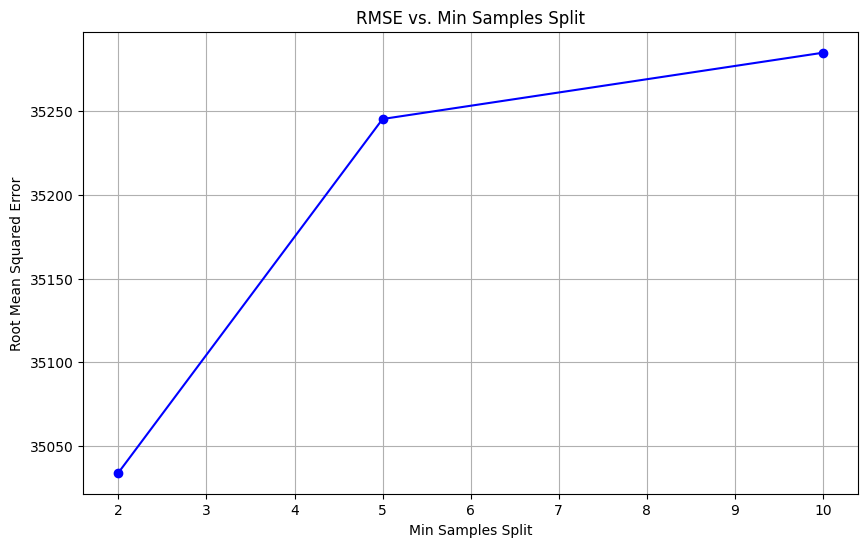

In [ ]:
grouped_min_samples = results_df.groupby('param_min_samples_split') # get a df object that is is grouped by the min_samples_split
mean_rmse = grouped_min_samples['rmse'].mean() # get the mean of each group
# print(f"Mean of each min_sample tested is: {mean_rmse}")
mean_rmse_df = mean_rmse.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_rmse_df['param_min_samples_split'], mean_rmse_df['rmse'], marker='o', linestyle='-', color='blue')
plt.title('RMSE vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

best_model = pipeline.named_steps['model'].best_estimator_
best_params = pipeline.named_steps['model'].best_params_
best_score = pipeline.named_steps['model'].best_score_
best_rmse = np.sqrt(-best_score)

print("Best Hyperparameters:", best_params)
print("Best RMSE(lowest):", best_rmse)

Best Hyperparameters: {'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE(lowest): 30880.96695528554




```
# This is formatted as code
```

#### Evaluate best model against X_val, y_val

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = pipeline.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)
# RMSE is a deviation error that we can use to see in general it looks like we are $28,550 off the actual price

Root Mean Squared Error (RMSE) on Validation Set: 28550.497769631103


In [ ]:
predictions = pipeline.predict(X_test)

In [ ]:
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


# Support Vector Machines (SVM)

#### Identify Hyperparameters & Define Model

In [28]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder # SVMs benefit from feature scaling
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import numpy as np

In [30]:
# Preprocess the numericalCols: any missing vals in cols replace with the median of that column apply standardScaler
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocess categorical data: imputer will handle the missing vals by replacing the vals with the most frequent in that col, onehot turns val into one hot encoded vector
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define a column transformer that applies OneHotEncoder to categorical columns and StandardScaler to numerical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numericalCols),
    ('cat', categorical_transformer, categoricalCols)
])

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svr__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR())
])

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Id',
                                                                          'MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'TotalBsmtS...
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'BsmtExposure',
                                                                          'BsmtFinType1',
                                                                          'BsmtFinType2',
                                                                          'Heating',
                                                                          'HeatingQC',
                                                                          'CentralAir',
                                                                          'Electrical',
                                                                          'KitchenQual',
                                                                          'Functional',
                                                                          'FireplaceQu', ...])])),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1, 10, 100],
                         'svr__gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [64]:
svr_best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_rmse = np.sqrt(-best_score)

# print("Best Model:", best_model)
print("Best Hyperparameters:", best_params)
print("Best RMSE(lowest):", best_rmse)

Best Hyperparameters: {'svr__C': 0.1, 'svr__gamma': 1, 'svr__kernel': 'poly'}
Best RMSE(lowest): 30999.06083977105


#### Evaluate best model against X_val, y_val

In [68]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = svr_best_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)

Root Mean Squared Error (RMSE) on Validation Set: 25985.16735786661


In [69]:
predictions = best_model.predict(X_test)

In [70]:
output = pd.DataFrame({'Id': X_test['Id'], 'SalePrice': predictions})
output.to_csv('submissionSVR.csv', index=False)
print("Submission saved!")

Submission saved!
